# Opto Analysis - Cohort 1
Analysis of firing rate changes during LC opto stimulation

In [1]:
# ==================== DATA ANALYSIS ====================

import pyabf 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy. signal import find_peaks
from matplotlib.ticker import MultipleLocator
import os

sns.set_context('notebook')

def detect_peaks(data_array, height_threshold=1, prominence_min=0.1, distance_min=5):
    peaks, properties = find_peaks(
        data_array,
        height=height_threshold,
        prominence=prominence_min,
        distance=distance_min
    )
    return peaks, properties

def calculate_firing_rates(abf_file, opto_start, opto_duration, cell_id):
    abf = pyabf.ABF(abf_file)
    results = []
    
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY
        
        before_mask = (time >= 0) & (time < opto_start)
        during_mask = (time >= opto_start) & (time < opto_start + opto_duration)
        after_start = time[-1] - 3.0 # last 3 seconds to allow to the cell to recover firing 
        after_mask = (time >= after_start) & (time <= time[-1])
        
        before_duration = opto_start
        during_duration = opto_duration
        after_duration = 3.0
        
        before_peaks, _ = detect_peaks(voltage[before_mask])
        during_peaks, _ = detect_peaks(voltage[during_mask])
        after_peaks, _ = detect_peaks(voltage[after_mask])
        
        before_rate = len(before_peaks) / before_duration if before_duration > 0 else 0
        during_rate = len(during_peaks) / during_duration if during_duration > 0 else 0
        after_rate = len(after_peaks) / after_duration if after_duration > 0 else 0
        
        results.append({
            'cell_id':  cell_id,
            'sweep': sweep,
            'before_opto':  before_rate,
            'during_opto':  during_rate,
            'after_opto': after_rate
        })
    
    return results

files_to_analyze = [
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0025.abf",
        'opto_start': 0.5,
        'opto_duration': 2.0,
        'cell_id': 'M1_C3'
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0028.abf",
        'opto_start': 0.5,
        'opto_duration': 2.0,
        'cell_id': 'M1_C3'
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M2\\2025_12_12_0008.abf",
        'opto_start': 5.0,
        'opto_duration':  2.0,
        'cell_id': 'M2_C2'
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M3\\2025_12_12_0020.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M3_C1'
    },
]

all_results = []
for file_info in files_to_analyze:
    results = calculate_firing_rates(
        abf_file=file_info['file'],
        opto_start=file_info['opto_start'],
        opto_duration=file_info['opto_duration'],
        cell_id=file_info['cell_id']
    )
    all_results.extend(results)

df = pd.DataFrame(all_results)
cell_means = df.groupby('cell_id')[['before_opto', 'during_opto', 'after_opto']].mean().reset_index()

print(f"\nAnalyzed {len(df)} sweeps from {df['cell_id'].nunique()} cells")
print("\nMean firing rates per cell:")
print(cell_means)


Analyzed 35 sweeps from 3 cells

Mean firing rates per cell:
  cell_id  before_opto  during_opto  after_opto
0   M1_C3     3.300000     1.850000    1.216667
1   M2_C2     0.514286     0.357143    0.095238
2   M3_C1     0.400000     0.125000    0.333333


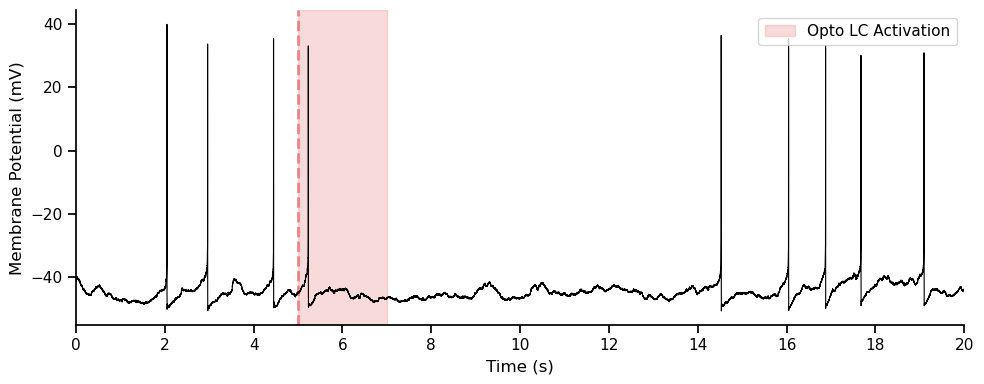

In [2]:
# ==================== EXAMPLE TRACE ====================

base_dir = "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1"
abf = pyabf.ABF(os.path.join(base_dir, "12.12.2025 M3\\2025_12_12_0020.abf"))
abf.setSweep(1)
time = abf.sweepX
voltage = abf.sweepY

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(time, voltage, color='black', linewidth=0.8)

opto_start = 5
opto_duration = 2.0
ax.axvspan(opto_start, opto_start + opto_duration, 
           color='#EB6F6F', alpha=0.25, label='Opto LC Activation', zorder=0)
ax.axvline(x=opto_start, color='#EB6F6F', linestyle='--', 
           linewidth=2, alpha=0.8, zorder=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Membrane Potential (mV)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, np.ceil(time. max())])
ax.xaxis.set_major_locator(MultipleLocator(2.0))
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

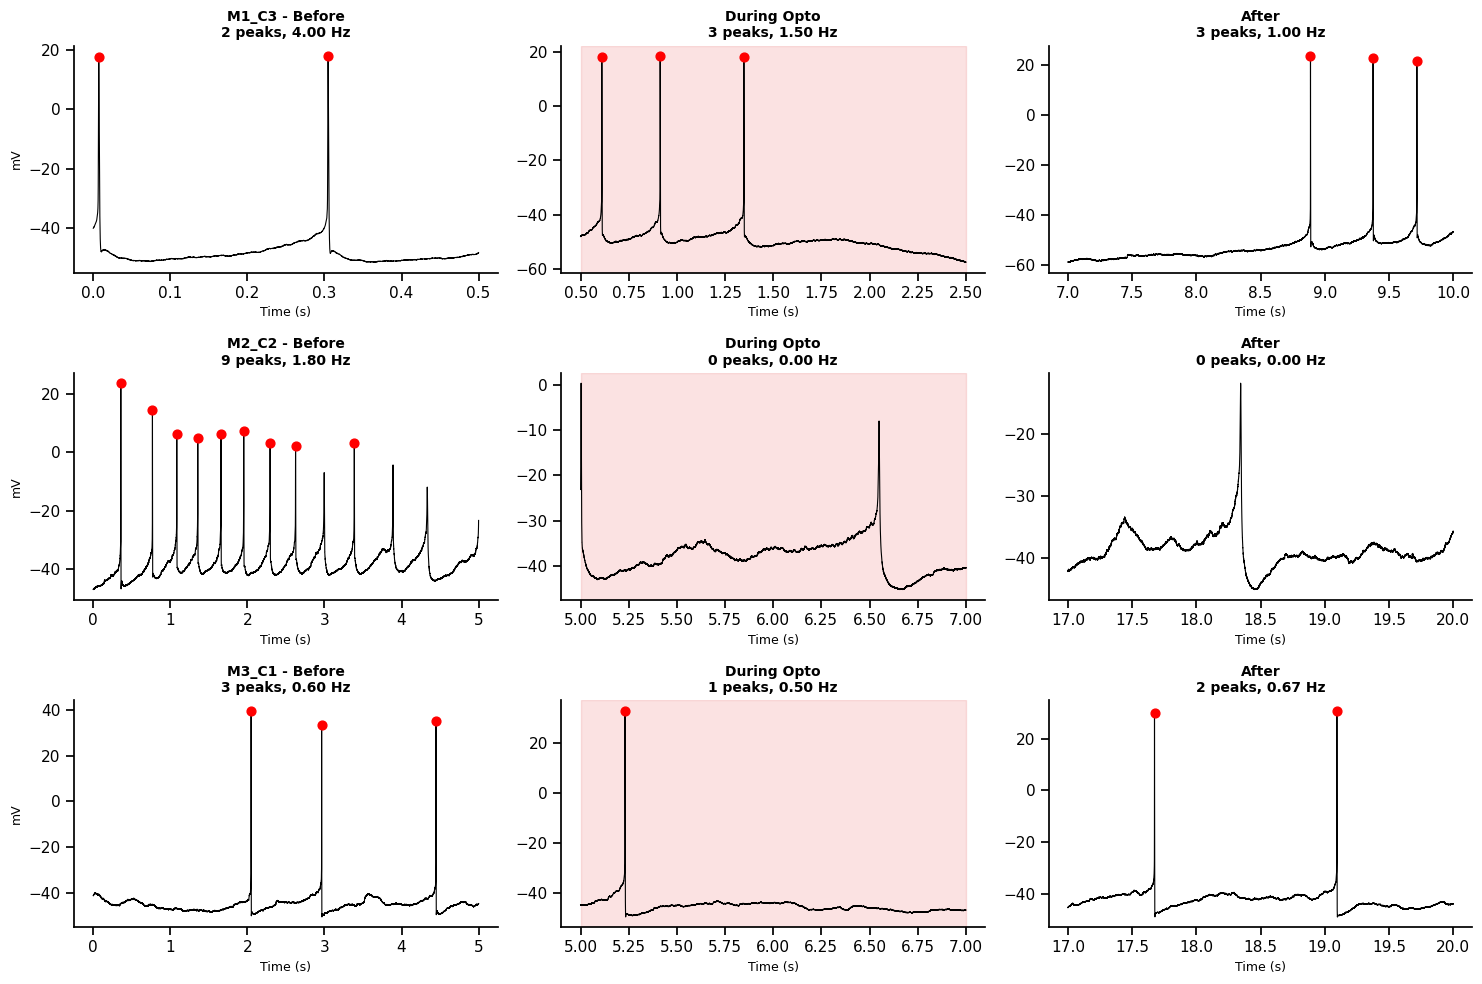

In [3]:
# ==================== PEAK DETECTION VALIDATION ====================

files_to_check = [
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0025.abf",
        'opto_start': 0.5,
        'opto_duration': 2.0,
        'cell_id': 'M1_C3',
        'sweep': 1
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M2\\2025_12_12_0008.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id':  'M2_C2',
        'sweep': 6
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M3\\2025_12_12_0020.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M3_C1',
        'sweep': 1
    },
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for idx, file_info in enumerate(files_to_check):
    abf = pyabf.ABF(file_info['file'])
    abf.setSweep(file_info['sweep'])
    time = abf.sweepX
    voltage = abf.sweepY
    
    opto_start = file_info['opto_start']
    opto_duration = file_info['opto_duration']
    after_start = time[-1] - 3.0
    
    before_mask = (time >= 0) & (time < opto_start)
    during_mask = (time >= opto_start) & (time < opto_start + opto_duration)
    after_mask = (time >= after_start) & (time <= time[-1])
    
    before_peaks, _ = detect_peaks(voltage[before_mask])
    during_peaks, _ = detect_peaks(voltage[during_mask])
    after_peaks, _ = detect_peaks(voltage[after_mask])
    
    before_duration = opto_start
    during_duration = opto_duration
    after_duration = 3.0
    
    before_rate = len(before_peaks) / before_duration
    during_rate = len(during_peaks) / during_duration
    after_rate = len(after_peaks) / after_duration
    
    ax = axes[idx, 0]
    ax.plot(time[before_mask], voltage[before_mask], 'k-', linewidth=0.8)
    if len(before_peaks) > 0:
        ax.scatter(time[before_mask][before_peaks], voltage[before_mask][before_peaks], 
                  color='red', s=40, zorder=5)
    ax.set_title(f"{file_info['cell_id']} - Before\n{len(before_peaks)} peaks, {before_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.set_ylabel('mV', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = axes[idx, 1]
    ax.plot(time[during_mask], voltage[during_mask], 'k-', linewidth=0.8)
    if len(during_peaks) > 0:
        ax.scatter(time[during_mask][during_peaks], voltage[during_mask][during_peaks], 
                  color='red', s=40, zorder=5)
    ax.axvspan(opto_start, opto_start + opto_duration, color='#EB6F6F', alpha=0.2, zorder=0)
    ax.set_title(f"During Opto\n{len(during_peaks)} peaks, {during_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = axes[idx, 2]
    ax.plot(time[after_mask], voltage[after_mask], 'k-', linewidth=0.8)
    if len(after_peaks) > 0:
        ax.scatter(time[after_mask][after_peaks], voltage[after_mask][after_peaks], 
                  color='red', s=40, zorder=5)
    ax.set_title(f"After\n{len(after_peaks)} peaks, {after_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for col in range(3):
        axes[idx, col].set_xlabel('Time (s)', fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
# ==================== NORMALIZATION:  RAW DATA ====================

data_raw = cell_means.copy()
print("Raw Firing Rates (Hz):")
print(data_raw)

Raw Firing Rates (Hz):
  cell_id  before_opto  during_opto  after_opto
0   M1_C3     3.300000     1.850000    1.216667
1   M2_C2     0.514286     0.357143    0.095238
2   M3_C1     0.400000     0.125000    0.333333


In [20]:
# ==================== NORMALIZATION: BASELINE (BEFORE = 1. 0) ====================

data_baseline = cell_means.copy()
data_baseline['baseline_norm'] = 1.0
data_baseline['during_norm'] = data_baseline['during_opto'] / data_baseline['before_opto']
data_baseline['after_norm'] = data_baseline['after_opto'] / data_baseline['before_opto']

print("Baseline-Normalized (Before = 1.0):")
print(data_baseline[['cell_id', 'baseline_norm', 'during_norm', 'after_norm']])

Baseline-Normalized (Before = 1.0):
  cell_id  baseline_norm  during_norm  after_norm
0   M1_C3            1.0     0.560606    0.368687
1   M2_C2            1.0     0.694444    0.185185
2   M3_C1            1.0     0.312500    0.833333


In [21]:
# ==================== NORMALIZATION: MIN-MAX ====================

data_minmax = cell_means.copy()

for idx, row in data_minmax. iterrows():
    values = [row['before_opto'], row['during_opto'], row['after_opto']]
    min_val = min(values)
    max_val = max(values)
    
    if max_val - min_val > 0:
        data_minmax.loc[idx, 'before_minmax'] = (row['before_opto'] - min_val) / (max_val - min_val)
        data_minmax. loc[idx, 'during_minmax'] = (row['during_opto'] - min_val) / (max_val - min_val)
        data_minmax.loc[idx, 'after_minmax'] = (row['after_opto'] - min_val) / (max_val - min_val)
    else:
        data_minmax.loc[idx, 'before_minmax'] = 0
        data_minmax.loc[idx, 'during_minmax'] = 0
        data_minmax.loc[idx, 'after_minmax'] = 0

print("Min-Max Normalized (0-1 scale):")
print(data_minmax[['cell_id', 'before_minmax', 'during_minmax', 'after_minmax']])

Min-Max Normalized (0-1 scale):
  cell_id  before_minmax  during_minmax  after_minmax
0   M1_C3            1.0          0.304      0.000000
1   M2_C2            1.0          0.625      0.000000
2   M3_C1            1.0          0.000      0.757576


In [22]:
# ==================== NORMALIZATION: PERCENT CHANGE ====================

data_pct = cell_means.copy()
data_pct['before_pct'] = 0.0
data_pct['during_pct'] = ((data_pct['during_opto'] - data_pct['before_opto']) / data_pct['before_opto']) * 100
data_pct['after_pct'] = ((data_pct['after_opto'] - data_pct['before_opto']) / data_pct['before_opto']) * 100

print("Percent Change from Baseline (%):")
print(data_pct[['cell_id', 'before_pct', 'during_pct', 'after_pct']])

Percent Change from Baseline (%):
  cell_id  before_pct  during_pct  after_pct
0   M1_C3         0.0  -43.939394 -63.131313
1   M2_C2         0.0  -30.555556 -81.481481
2   M3_C1         0.0  -68.750000 -16.666667


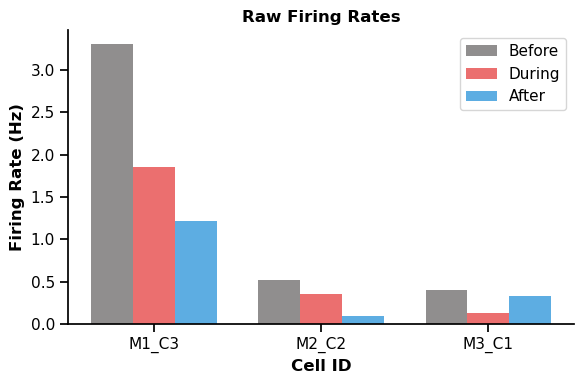

In [23]:
# ==================== PLOT:  BAR GRAPH (RAW DATA) ====================

fig, ax = plt.subplots(figsize=(6, 4))

x = np.arange(len(data_raw))
width = 0.25

bars1 = ax.bar(x - width, data_raw['before_opto'], width, label='Before', color='#908E8E')
bars2 = ax.bar(x, data_raw['during_opto'], width, label='During', color='#EB6F6F')
bars3 = ax.bar(x + width, data_raw['after_opto'], width, label='After', color='#5DADE2')

ax.set_xlabel('Cell ID', fontweight='bold')
ax.set_ylabel('Firing Rate (Hz)', fontweight='bold')
ax.set_title('Raw Firing Rates', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(data_raw['cell_id'])
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

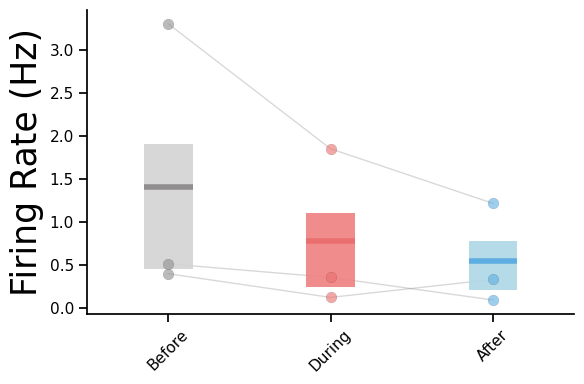

In [24]:
# ==================== PLOT:  BOXPLOT WITH LINES (RAW DATA) ====================

colors = ['lightgrey', 'lightcoral', 'lightblue']
colors_bar = ["#908E8E", "#EB6F6F", "#5DADE2"]

fig, ax = plt.subplots(figsize=(6, 4))

conditions = ['Before', 'During', 'After']
box_data = [
    data_raw['before_opto']. values,
    data_raw['during_opto'].values,
    data_raw['after_opto'].values
]

box = ax.boxplot(
    box_data,
    positions=range(3),
    widths=0.3,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='none'),
    boxprops=dict(facecolor='none', edgecolor='none'),
    whiskerprops=dict(color='none'),
    capprops=dict(color='none')
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.9)

for _, row in data_raw.iterrows():
    y = [row['before_opto'], row['during_opto'], row['after_opto']]
    x = [0, 1, 2]
    ax.plot(x, y, color='gray', alpha=0.3, linewidth=1, zorder=1)
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.scatter(xi, yi, color=colors_bar[i], alpha=0.6, s=60, zorder=2,
                  edgecolors='black', linewidths=0.1)

box_width = 0.3
for i, col in enumerate(['before_opto', 'during_opto', 'after_opto']):
    y_vals = data_raw[col].values
    ax.hlines(np.mean(y_vals), i - box_width/2, i + box_width/2,
             color=colors_bar[i], linewidth=4, zorder=3)

ax. set_ylabel('Firing Rate (Hz)', fontsize=25)
ax.set_xticks(range(3))
ax.set_xticklabels(conditions, rotation=45)
ax.set_xlim(-0.5, 2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

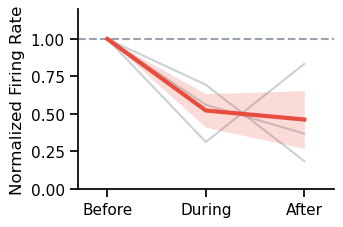

In [26]:
# ==================== PLOT:  LINE PLOT WITH SEM (BASELINE NORMALIZED) ====================

fig, ax = plt.subplots(figsize=(3.5, 2.5), facecolor='white')
ax.set_facecolor('white')

mean_values = [
    data_baseline['baseline_norm'].mean(),
    data_baseline['during_norm'].mean(),
    data_baseline['after_norm'].mean()
]
sem_values = [
    data_baseline['baseline_norm'].sem(),
    data_baseline['during_norm'].sem(),
    data_baseline['after_norm'].sem()
]

timepoints = [0, 1, 2]

for idx, row in data_baseline.iterrows():
    values = [row['baseline_norm'], row['during_norm'], row['after_norm']]
    ax.plot(timepoints, values, 
            color='#95A5A6', linewidth=1.5, alpha=0.5, zorder=5)

upper_bound = [m + s for m, s in zip(mean_values, sem_values)]
lower_bound = [m - s for m, s in zip(mean_values, sem_values)]
ax.fill_between(timepoints, lower_bound, upper_bound, 
                alpha=0.2, color='#E74C3C', linewidth=0, zorder=8)

ax.plot(timepoints, mean_values, 
        color='#E74C3C', linewidth=3, label='Mean ± SEM', zorder=10)

ax.axhline(1.0, color='#34495E', linestyle='--', linewidth=1.5, alpha=0.5, zorder=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Before', 'During', 'After'])
ax.set_ylabel('Normalized Firing Rate')
ax.set_xlim(-0.3, 2.3)
ax.set_ylim(0, max(upper_bound) * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

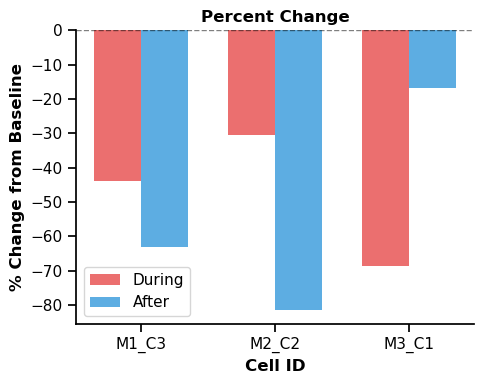

In [27]:
# ==================== PLOT:  PERCENT CHANGE BAR GRAPH ====================

fig, ax = plt.subplots(figsize=(5, 4))

x = np. arange(len(data_pct))
width = 0.35

bars1 = ax.bar(x - width/2, data_pct['during_pct'], width, label='During', color='#EB6F6F')
bars2 = ax. bar(x + width/2, data_pct['after_pct'], width, label='After', color='#5DADE2')

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Cell ID', fontweight='bold')
ax.set_ylabel('% Change from Baseline', fontweight='bold')
ax.set_title('Percent Change', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(data_pct['cell_id'])
ax.legend()
ax.spines['top']. set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()